# import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import f1_score
# from torchcontrib.optim import SWA
from transformers import AutoTokenizer, AutoModel, AutoConfig,BertModel, BertTokenizer
# from torchcontrib.optim import SWA

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn import model_selection
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
import gc
gc.enable()




In [2]:
class args:
    train_path = r"C:\Users\ajayp\OneDrive\Desktop\Semantic_similarity\data\training_file.csv"
    test_path = r"C:\Users\ajayp\OneDrive\Desktop\Semantic_similarity\data\testing_file.csv"
    TOKENIZER_PATH = "bert-base-uncased"
    BERT_PATH = "bert-base-uncased"
    ROBERTA_PATH = "roberta-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
    MAX_LEN = 256
    train_batch_size = 16
    valid_batch_size = 1
    epochs = 15
    model_path = r"C:\Users\ajayp\OneDrive\Desktop\Semantic_similarity\Saved_model_weights"
    folds_path = r"C:\Users\ajayp\OneDrive\Desktop\Semantic_similarity\data\train_folds.csv"
    splits  = 5




In [3]:
train_df = pd.read_csv(args.train_path)
test_df = pd.read_csv(args.test_path)


# EDA

In [4]:
train_df.describe()

,label
count,10461.000000
mean,0.456935
std,0.498166
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10461 entries, 0 to 10460
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    10461 non-null  object 
 1   reason  10461 non-null  object 
 2   label   10461 non-null  float64
dtypes: float64(1), object(2)
memory usage: 245.3+ KB


In [6]:
train_df.value_counts().sum()

10461

In [7]:
test_df.iloc[0]

text      everytime i download this app on my galaxy s9,...
reason         getting blank screen after launching the app
label                                                     1
Name: 0, dtype: object

In [8]:
print(train_df["text"][0])
print(train_df["reason"][0])


so far I am going to get screwed because I have already paid for a month (which they will not redeem any of i assure you even though i only started it yesterday) and it is unwatchable.
want to cancel subscription


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    600 non-null    object 
 1   reason  600 non-null    object 
 2   label   600 non-null    float64
dtypes: float64(1), object(2)
memory usage: 14.2+ KB


In [10]:
test_df.describe()

,label
count,600.000000
mean,0.470000
std,0.499516
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
test_df["label"].value_counts()

0.0    318
1.0    282
Name: label, dtype: int64

# plots


<AxesSubplot:xlabel='label', ylabel='count'>

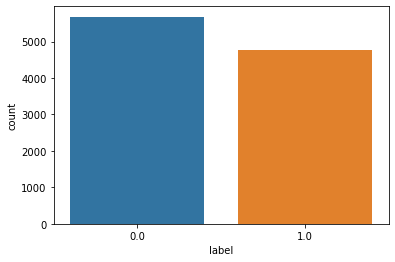

In [12]:
sns.countplot(x=train_df["label"])
# this shows the high imbalance in the dataset

<AxesSubplot:xlabel='label', ylabel='count'>

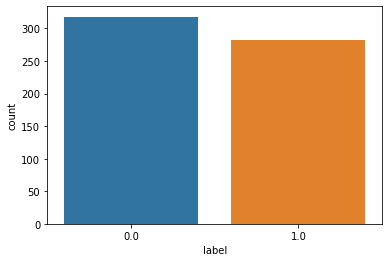

In [13]:
sns.countplot(x = test_df["label"])
# test data comprises of completely single label 
# so it will be of now use to consider test data as a training set
# so here we can use evaluation data as the training dataset 

In [14]:
# frames = [train_df, test_df]

# train_df_new = pd.concat(frames)
# train_df_new = train_df_new.reset_index(drop = True)
# train_df_new

In [15]:
# sns.countplot(x=train_df_new["label"])

In [16]:
# df = train_df_new.sample(frac = 1)
# df.reset_index(drop = True, inplace = True)
# test_df_new = df.iloc[-600:]
# df = df.iloc[:-600]
# df.reset_index(drop = True, inplace = True)
# test_df_new.reset_index(drop = True, inplace = True)
# print(df.shape, test_df_new.shape)

# df.to_csv("training_file.csv", index = False)
# test_df_new.to_csv("testing_file.csv", index = False)

## get count of the new data file
# sns.countplot(x=test_df_new["label"])

# Dataset class

In [17]:
# sen_1 = train_df["text"][0]
# sen_2 = train_df["reason"][0]
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# tokenizer.encode_plus(sen_1, 
#                       sen_2,
#                       padding = "max_length", 
#                       add_special_tokens = True, 
#                       truncation = True, 
#                       return_attention_mask = True)

In [18]:
class Data_class(Dataset):
    def __init__(self, df,args, inference_only=False):
        super().__init__()
        
        self.df = df      
#         df["airline_sentiment"] = df["airline_sentiment"].apply(lambda x : add_sentiment(x))
        self.inference_only = inference_only
#         self.text = df.text.tolist()
        
        if not self.inference_only:
            self.target = torch.tensor(df.label.values, dtype=torch.float)     
            
        self.sen_1 = df["text"].tolist()
        self.sen_2 = df["reason"].tolist()
    
        self.encoded = args.tokenizer.encode_plus(str(self.sen_1), 
                      str(self.sen_2),
                      padding = "max_length", 
                      add_special_tokens = True, 
                      truncation = True, 
                      return_attention_mask = True)      
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):    
        
        encoded = args.tokenizer.encode_plus(self.sen_1[index], 
                      self.sen_2[index],
                      padding = "max_length", 
                      add_special_tokens = True,
                      max_length = args.MAX_LEN,
                      truncation = True, 
                      return_attention_mask = True)   
        input_ids = torch.tensor(encoded["input_ids"])
        attention_mask = torch.tensor(encoded["attention_mask"])
        token_type_ids = torch.tensor(encoded["token_type_ids"])
        
        
        if self.inference_only:
            return {
                "input_ids" : input_ids, 
                "attention_mask" : attention_mask, 
                "token_type_ids" : token_type_ids
            }           
        else:
            target = self.target[index]
            return {
                "input_ids" : input_ids, 
                "attention_mask" : attention_mask, 
                "token_type_ids" : token_type_ids,
                "target" : target
            }

# model (Bert Base)

In [19]:
class SEN_Model(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(args.BERT_PATH)
        config.update({"output_hidden_states":True, 
                       "layer_norm_eps": 1e-7})                       
        self.layer_start = 9
        self.bert = AutoModel.from_pretrained(args.BERT_PATH, config=config)  

        self.attention = nn.Sequential(            
            nn.Linear(768, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        

        self.linear = nn.Linear(768, 1)
#         self.softmax = nn.Softmax(dim = -1)
        

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        #print(outputs)
        #all_hidden_state = outputs.hidden_states[-1]
       # weighted_pooling_embeddings = self.pooler(all_hidden_state)
#         print(outputs.hidden_states[-1].shape)
        
        weights = self.attention(outputs.hidden_states[-1])
        #[batch_size, max_len, hidden_states]
#         print(weights.shape)
        
       
        context_vector = torch.sum(weights *outputs.hidden_states[-1] , dim=1) 
#         print((weights *outputs.hidden_states[-1]).shape)
#         print(context_vector.shape)
        
        return self.linear(context_vector)

In [20]:
# temp = Data_class(train_df, args)
# sample = temp.__getitem__(10)
# # sample

# for i, data  in enumerate(tqdm(temp, total = len(temp))):
#     try:
#         pass
# #         print(temp.__getitem__(i)["input_ids"].shape,temp.__getitem__(i)["attention_mask"].shape,temp.__getitem__(i)["token_type_ids"].shape )
#     except:
#         print("Here is the error")
# model = SEN_Model()
# input_ids, attention_mask, token_type_ids = sample["input_ids"].unsqueeze(0), sample["attention_mask"].unsqueeze(0), sample["token_type_ids"].unsqueeze(0)
# out = model(input_ids, attention_mask, token_type_ids)
# pred = torch.sigmoid(out)
# print(pred)

In [21]:
def train_fn(data_loader, model, optimizer,device, scheduler):
    model.train()
    
    loss_sum = 0
    
    for i, data in tqdm(enumerate(data_loader), total = len(data_loader)):
        input_ids = data["input_ids"]
        attention_mask = data["attention_mask"]
        token_type_ids = data["token_type_ids"]
        target = data["target"]
        
        input_ids = input_ids.to(device, dtype = torch.long)
        attention_mask = attention_mask.to(device, dtype = torch.long)
        target = target.to(device, dtype = torch.float)
        token_type_ids = token_type_ids.to(device, dtype = torch.long)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, target)
        loss.backward()
        
        loss_sum += loss.item()
        
        optimizer.step()
        scheduler.step()
        
        
    return loss_sum/len(data_loader)
        
        
    
    
def eval_fn(data_loader, model, device):
    
    model.eval()
    
    final_targets = []
    
    final_outputs = []
    
    with torch.no_grad():
            
        for i, data in tqdm(enumerate(data_loader), total = len(data_loader)):
            input_ids = data["input_ids"]
            attention_mask = data["attention_mask"]
            token_type_ids = data["token_type_ids"]
            target = data["target"]

            input_ids = input_ids.to(device, dtype = torch.long)
            attention_mask = attention_mask.to(device, dtype = torch.long)
            target = target.to(device, dtype = torch.float)
            token_type_ids = token_type_ids.to(device, dtype = torch.long)
            
            outputs = model(input_ids, attention_mask, token_type_ids)
            
            output = torch.sigmoid(outputs)
            
#             ans = torch.argmax(output, dim = -1)
            
            targets = target.detach().cpu().numpy().tolist()
            
            ans = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            
            final_outputs.extend(ans)
            
    return final_outputs, final_targets

In [22]:
import torch.nn as nn


def loss_fn(out, tar):
#     print(out)
#     print(tar)
    loss = nn.BCEWithLogitsLoss()(out, tar.view(-1, 1))
    return loss

# print(loss_fn(out.flatten(), tar))

# Cross Validation(k fold)

In [23]:
# import pandas as pd
# from sklearn import model_selection
# # from args import args

# # Training data is in a csv file called train.csv 
# df = pd.read_csv(args.train_path)
# # we create a new column called kfold and fill it with -1
# df["kfold"] = -1

# # fetch targets
# y = df.label.values

# # initiate the kfold class from model_selection module
# kf = model_selection.StratifiedKFold(n_splits=args.splits, shuffle=True, random_state=42)

# # fill the new kfold column
# for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
#     df.loc[v_, 'kfold'] = f

# # save the new csv with kfold column
# df.to_csv("train_folds.csv", index=False)

In [24]:
def run(fold):
    df = pd.read_csv(args.folds_path)
    df = df.iloc[:50]
#     df_train, df_valid = model_selection.train_test_split(df, test_size = 0.1, random_state = 42)
    
    df_train = df[df["kfold"] != fold]
    df_valid = df[df["kfold"] == fold]
    
    
    df_train = df_train.reset_index(drop = True)
    df_valid = df_valid.reset_index(drop = True)
    
    train_dataset = Data_class(df_train, args)
    valid_dataset = Data_class(df_valid, args)
    
    
#     print(args.train_batch_size, args.valid_batch_size)
    
    train_loader = DataLoader(train_dataset, batch_size = args.train_batch_size, shuffle = True)
    valid_loader = DataLoader(valid_dataset, batch_size = args.valid_batch_size)
    
    device = torch.device("cuda")
    model = SEN_Model()
    
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    
    optimizer_parameters = [
        {'params' : [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params' : [p for n, p in param_optimizer if  any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    
    num_training_steps = int(len(df_train)/args.train_batch_size)*args.epochs
    
    optimizer = AdamW(optimizer_parameters, lr = 3e-5)
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = num_training_steps)
    
    model = model.to(device)
    loss_list = []
    
    best_val = -1
    
#     opt = SWA(optimizer, swa_start=10, swa_freq=5, swa_lr=0.05)
    
    for epoch in range(args.epochs):
        loss = train_fn(train_loader, model, optimizer, device, scheduler)
#         print(loss)
        loss_list.append(loss)
        final_out, final_tar = eval_fn(valid_loader, model, device)
        print("================loss============", loss)
#         print(metrics.classification_report(final_out, final_tar))
        
#         print("================validation===========")
    
#         f1_scores = f1_score(final_tar, final_out, average=None, labels=labels)
    
#         print("=============f1_scores======================", f1_scores)
        
#         f1_mean = f1_scores.mean()
#         print("=============f1_scores mean======================", f1_mean)

        outputs = np.array(final_out) >= 0.5
        accuracy = metrics.accuracy_score(final_tar, outputs)
        f1_score = metrics.f1_score(final_tar, outputs)
        
        print(r"============accuracy========{accuracy} ".format(accuracy = accuracy))
        print(r"============f1_score========{f1_score} ".format(f1_score = f1_score))
        
        if best_val < f1_score:
            print("======saving model============")
            best_val = f1_score
            model_path = args.model_path + '\\' + r"model_{fold}_.pth".format(fold = fold)
            # model_path = r"/kaggle/working/model{fold}".format(fold = fold)
            torch.save(model.state_dict(), model_path)
    loss_path = r"\Users\ajayp\OneDrive\Desktop\Project\Saved_model_weights\model_{fold}_.pickle".format(fold = fold)
    # loss_path = r'/kaggle/working/loss_path{fold}'.format(fold = fold)
    with open(loss_path, 'wb') as f:
        pickle.dump(loss_list, f)
        
        
        
# if __name__ == "__main__":
# #     run(fold = 0)
#     run(fold = 1)
# #     run(fold = 2)
# #     run(fold = 3)
# #     run(fold = 4)

In [26]:
if __name__ == "__main__":
    run(fold = 0)
    run(fold = 1)
    run(fold = 2)
    run(fold = 3)
    run(fold = 4)